# <span style="color:blue">Game AB Testing</span>

### <span style="color:blue">Project Overview</span>
This dataset was sourced from [Kaggle](https://www.kaggle.com/yufengsui/mobile-games-ab-testing) 
and contains player data from a popular mobile puzzle game. More details about the game can be 
found on the developer's [website](https://tactilegames.com/cookie-cats/).

In short, this project seeks to use A/B testing to explore the impact of a particular game 
mechanic on player retention. A random sampling of the overall playerbase will be pulled in to 
this case study: half serving as a test group to measure the outcome of a different progression 
system, and half as a control group to contrast with the above. The dataset will log "user 
interaction" as cumulative rounds played, and "frequency of play" as logins after pre-defined 
time intervals. Later statistical analysis of this data should yield a determination on the merit 
of this proposed game change.

### <span style="color:blue">Data Exploration</span>

In [1]:
# global imports
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown, display
from scipy import stats

In [2]:
# markdown print function
def printmd(text):
    display(Markdown(text))

In [3]:
# loading data
df = pd.read_csv('cookie_cats.csv')
print(df)

        userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3        False        False
1          337  gate_30              38         True        False
2          377  gate_40             165         True        False
3          483  gate_40               1        False        False
4          488  gate_40             179         True         True
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False

[90189 rows x 5 columns]


Columns descriptions:
  1. userid: integer, unique user identifier number
  2. version: string, player group name; gate_30 is the control group
  3. sum_gamerounds: integer, rounds played in week following install
  4. retention_1: bool, games played one day after install
  5. retention_7: bool, games played seven days after install

In [4]:
# column info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


90189 rows, each belonging to a unique user who installed the game during this test interval (one 
week). The dataset doesn't contain any null values, and all columns have reasonable data types.

In [5]:
# numerical stats
print(df.groupby('version').sum_gamerounds.describe())

           count       mean         std  min  25%   50%   75%      max
version                                                               
gate_30  44700.0  52.456264  256.716423  0.0  5.0  17.0  50.0  49854.0
gate_40  45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0   2640.0


Right away it is apparent that "sum_gamerounds" has at least one rather large outlier (and 
potentially others, though not quite as egregious); 75% of values lie between 0 and 51, yet the 
max value is 49854.

<AxesSubplot:title={'center':'sum_gamerounds'}, xlabel='[version]'>

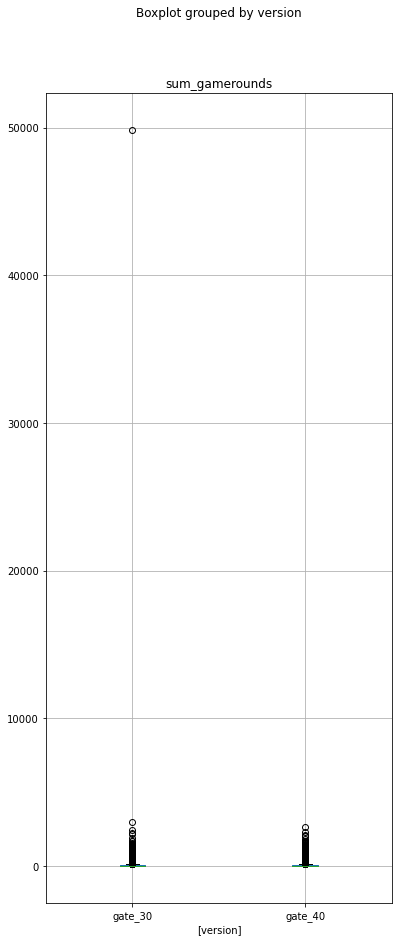

In [6]:
# visualizing outliers
fig, ax = plt.subplots()
fig.set_size_inches(6, 15)
df.boxplot(column = ['sum_gamerounds'], by = ['version'], ax = ax)

Dropping rows with "sum_gamerounds" greater than 10000 should remove this outlier and bring these 
box and whisker plots more in line.

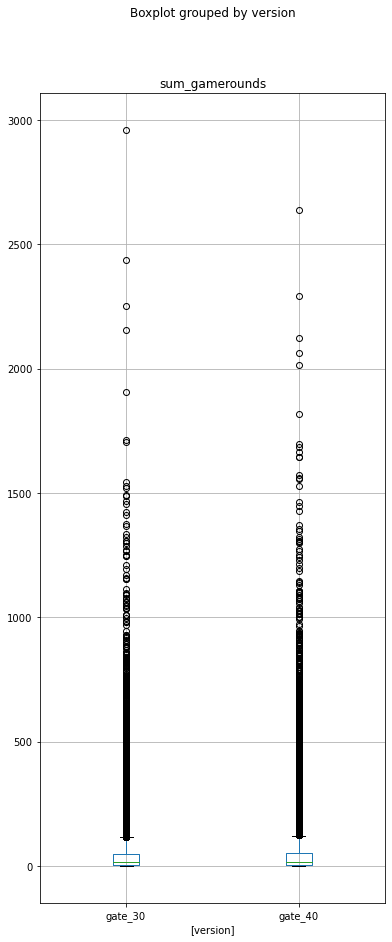

           count       mean         std  min  25%   50%   75%     max
version                                                              
gate_30  44699.0  51.342111  102.057598  0.0  5.0  17.0  50.0  2961.0
gate_40  45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0  2640.0


In [7]:
# outlier removal
df = df.query('sum_gamerounds < 10000')
fig, ax = plt.subplots()
fig.set_size_inches(6, 15)
df.boxplot(column = ['sum_gamerounds'], by = ['version'], ax = ax)
plt.show()
print(df.groupby('version').sum_gamerounds.describe())

There are still quite a few outliers (per the more standard 1.5*IQR rule), we may return to 
further reduce outliers pending analysis.

In [8]:
# categorical stats
print(df.iloc[:, [1, 3, 4]].apply(pd.Series.value_counts))

         version  retention_1  retention_7
gate_40  45489.0          NaN          NaN
gate_30  44699.0          NaN          NaN
False        NaN      50035.0      73408.0
True         NaN      40153.0      16780.0


The two groups "gate_30" and "gate_40" split the entire dataset pretty much down the middle, 
though the same cannot be said for the boolean values of the two retention columns. 55% of 
new players did not return to play on day one, while an even greater percentage (81%) did not 
return on day seven. At a cursory glance, long term retention would be the more significant task 
to try to tackle.

In [9]:
# retention percentages
print(df.groupby('version')[['retention_1', 'retention_7']].mean())

         retention_1  retention_7
version                          
gate_30     0.448198     0.190183
gate_40     0.442283     0.182000


Day one and seven retention both look to average out to slightly higher values for "gate_30", 
approximately .006 and .008 respectively, though keep in mind these numbers alone aren't enough 
to prove anything. That said, the closeness of these between-group comparisons stresses that the 
impact from this A/B test is minimal.

In [10]:
# retention breakdown
retention_breakdown = df.groupby(['version', 'retention_1', 'retention_7']).userid.agg('count') \
    .groupby(level = 0).apply(lambda x: 100*x/float(x.sum()))
printmd('**Retention by boolean combination**')
print(retention_breakdown, '\n')
columns = ['gate_30 -> 40 deltas']
index = ['F-F', 'F-T', 'T-F', 'T-T']
retention_deltas = retention_breakdown[['gate_40']].values-retention_breakdown[['gate_30']].values
printmd('**Between group retention deltas**')
print(pd.DataFrame(retention_deltas, index = index, columns = columns))

**Retention by boolean combination**

version  retention_1  retention_7
gate_30  False        False          51.097340
                      True            4.082865
         True         False          29.884337
                      True           14.935457
gate_40  False        False          51.874079
                      True            3.897646
         True         False          29.925916
                      True           14.302359
Name: userid, dtype: float64 



**Between group retention deltas**

     gate_30 -> 40 deltas
F-F              0.776739
F-T             -0.185220
T-F              0.041579
T-T             -0.633098


A quick description of the four boolean combinations:

  1. F-F: no logins on days 1, 7; no retention
  2. F-T: login only on day 7; long term retention
  3. T-F: login only on day 1; short term retention
  4. T-T: logins on days 1, 7; overall retention

Depending on what type of retention we were seeking to improve (i.e. short, long term), 
our initial conclusion would be slightly different. Long term retention looks to generally have 
been negatively impacted in the "gate_40" group, while short term retention saw the opposite 
effect. Table 1 above displays percentages per boolean combo for each group, and table 2 the 
percentage delta going from "gate_30" to "gate_40". In plaintext english:

  1. +.78% failure to retain (F-F)
  2. -.19% long term retention (F-T)
  3. +.04 short term retention (T-F)
  4. -.63 overall retention (T-T)

### <span style="color:blue">Hypotheses: Independence</span>

Let:

  - H<sub>0</sub>: version does not impact retention (independent)
  - H<sub>a</sub>: version does impact retention (dependent)

This initial test will be looking at whether we can conclude, beyond a reasonable doubt, that 
there is a correlation between version and retention. Since our "version", "retention_1", and 
"retention_7" columns are categorical variables, a non-parametric test like chi2 seems like a 
good fit. A standard significance value of α = .05 will be used.

In [11]:
# retention counts
retention_counts = df.groupby(['version', 'retention_1', 'retention_7']).userid.count()
a = retention_counts['gate_30'].values
b = retention_counts['gate_40'].values
chi2, p, dof, ex = stats.chi2_contingency([a, b], correction = False)
printmd('**Results**')
print('Chi Statistic: {}\nP-value: {}\nDegrees of Freedom: {}'.format(chi2, p, dof))

**Results**

Chi Statistic: 10.776026093423667
P-value: 0.013000737455766848
Degrees of Freedom: 3


Our p-value is indeed smaller than our significance value, so the evidence points to a rejection 
of the null hypothesis; version and retention have a dependent relationship.